
# WiDS Datathon 2025 — ADHD & Gender Classification

As part of the WiDS Datathon 2025 challenge, participants were tasked with a **multi-output classification** problem:  
to predict the presence of **ADHD (Attention Deficit Hyperactivity Disorder)** and the **gender** of a patient based on the provided data.

Two sources of features were used:
- **Tabular metadata** (quantitative and categorical),
- **FMRI connectome matrices** (functional MRI brain data).

I implemented an ensemble of two models:
- A separate model trained on tabular features (`XGBoost` + `MultiOutputClassifier`),
- A separate model trained on FMRI matrices,
- Their predictions were averaged to improve final accuracy.




In [34]:
!pip install -q scikit-learn==1.2.2 imbalanced-learn==0.10.1 phik xgboost matplotlib seaborn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.8 MB/s eta 0:00:0000:01


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
# 3) File paths & Data loading (Kaggle)
cat_path    = '/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx'
num_path    = '/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx'
target_path = '/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx'
fmri_path   = '/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv'

cat_df    = pd.read_excel(cat_path)
num_df    = pd.read_excel(num_path)
target_df = pd.read_excel(target_path)
fmri_df   = pd.read_csv(fmri_path)

In [17]:
df = cat_df.merge(num_df, on="participant_id").merge(target_df, on="participant_id")

## 📊 Exploratory Data Analysis (EDA)

In [18]:
print("\nUnique values in categorical columns:")
for col in ['Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity',
            'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location']:
    print(f"{col}: {df[col].nunique()} unique values")


Unique values in categorical columns:
Basic_Demos_Study_Site: 4 unique values
PreInt_Demos_Fam_Child_Ethnicity: 4 unique values
PreInt_Demos_Fam_Child_Race: 10 unique values
MRI_Track_Scan_Location: 4 unique values


In [19]:
print("\nTarget class distribution:")
print("Sex_F:\n", df["Sex_F"].value_counts(normalize=True))
print("ADHD_Outcome:\n", df["ADHD_Outcome"].value_counts(normalize=True))


Target class distribution:
Sex_F:
 Sex_F
0    0.657049
1    0.342951
Name: proportion, dtype: float64
ADHD_Outcome:
 ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64


## 📌 Target Variables Distribution (Sex & ADHD)

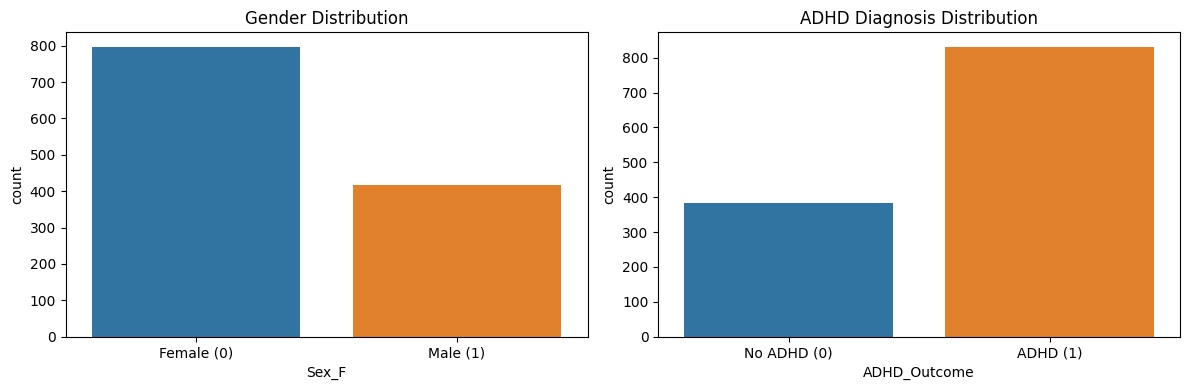

In [30]:
# Plotting distribution of target labels
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='Sex_F', data=df, ax=axs[0])
axs[0].set_title('Gender Distribution')
axs[0].set_xticklabels(['Female (0)', 'Male (1)'])

sns.countplot(x='ADHD_Outcome', data=df, ax=axs[1])
axs[1].set_title('ADHD Diagnosis Distribution')
axs[1].set_xticklabels(['No ADHD (0)', 'ADHD (1)'])

plt.tight_layout()
plt.show()

## 🧠 FMRI Connectome Matrix Visualization

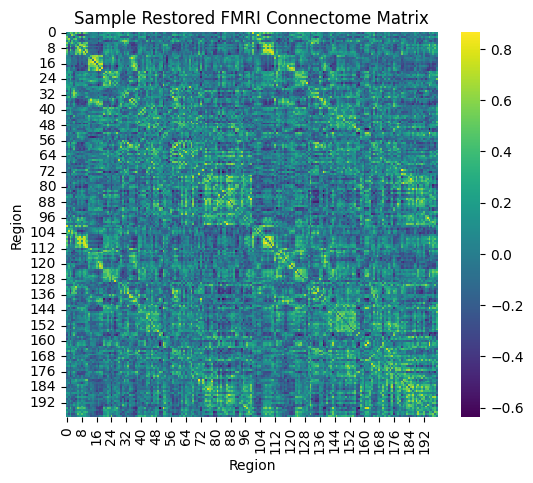

In [28]:

# Restore a symmetric FMRI connectome matrix from a vector
def restore_symmetric_matrix(vec, size):
    mat = np.zeros((size, size))
    triu_indices = np.triu_indices(size, k=1)
    mat[triu_indices] = vec
    mat += mat.T  # make symmetric
    return mat

# Try restoring and plotting the first sample
vec = fmri_df.iloc[0, 1:].values  # skip ID column
sym_matrix = restore_symmetric_matrix(vec, size=200)

plt.figure(figsize=(6, 5))
sns.heatmap(sym_matrix, cmap='viridis')
plt.title("Sample Restored FMRI Connectome Matrix")
plt.xlabel("Region")
plt.ylabel("Region")
plt.show()

Missing value percentage:
 participant_id                       0.00
Basic_Demos_Enroll_Year              0.00
Basic_Demos_Study_Site               0.00
PreInt_Demos_Fam_Child_Ethnicity     3.54
PreInt_Demos_Fam_Child_Race          4.45
MRI_Track_Scan_Location              0.25
Barratt_Barratt_P1_Edu               1.24
Barratt_Barratt_P1_Occ               2.56
Barratt_Barratt_P2_Edu              16.32
Barratt_Barratt_P2_Occ              18.30
EHQ_EHQ_Total                        1.07
ColorVision_CV_Score                 1.90
APQ_P_APQ_P_CP                       0.99
APQ_P_APQ_P_ID                       0.99
APQ_P_APQ_P_INV                      0.99
APQ_P_APQ_P_OPD                      0.99
APQ_P_APQ_P_PM                       0.99
APQ_P_APQ_P_PP                       0.99
SDQ_SDQ_Conduct_Problems             0.74
SDQ_SDQ_Difficulties_Total           0.74
SDQ_SDQ_Emotional_Problems           0.74
SDQ_SDQ_Externalizing                0.74
SDQ_SDQ_Generating_Impact            0.74
SDQ_SDQ

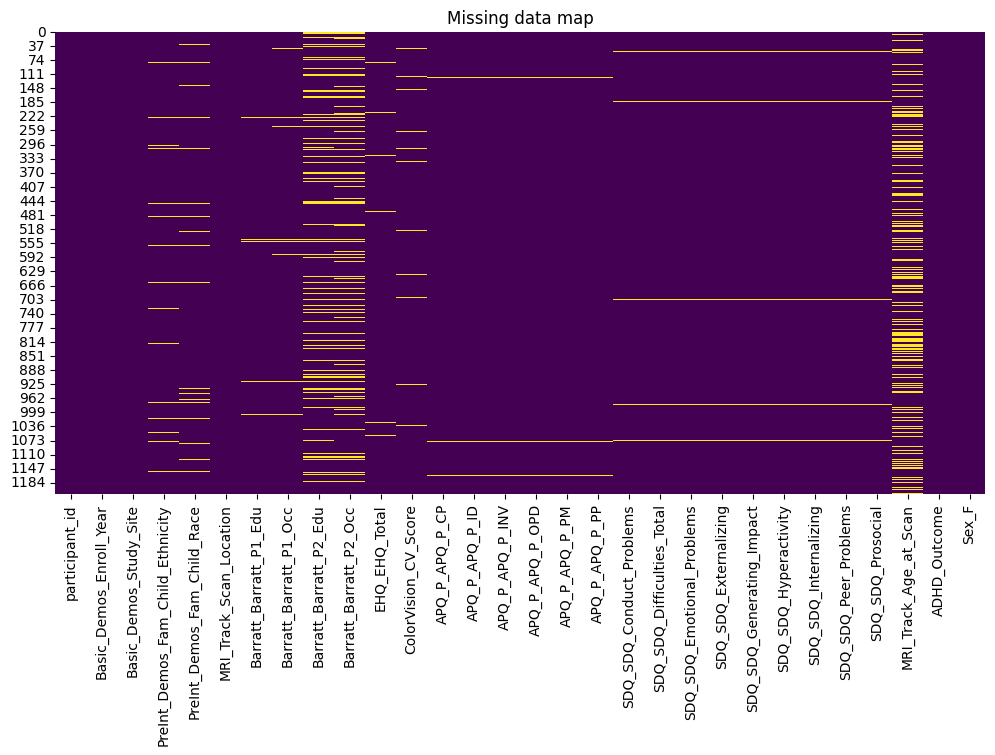


Missing in PreInt_Demos_Fam_Child_Ethnicity by ADHD_Outcome:
 ADHD_Outcome
0    0.065445
1    0.021661
Name: PreInt_Demos_Fam_Child_Ethnicity, dtype: float64
Missing in PreInt_Demos_Fam_Child_Ethnicity by Sex_F:
 Sex_F
0    0.032622
1    0.040865
Name: PreInt_Demos_Fam_Child_Ethnicity, dtype: float64

Missing in MRI_Track_Age_at_Scan by ADHD_Outcome:
 ADHD_Outcome
0    0.285340
1    0.302046
Name: MRI_Track_Age_at_Scan, dtype: float64
Missing in MRI_Track_Age_at_Scan by Sex_F:
 Sex_F
0    0.296110
1    0.298077
Name: MRI_Track_Age_at_Scan, dtype: float64


In [26]:
# Percentage of missing values
print("Missing value percentage:\n", (df.isnull().sum() / len(df) * 100).round(2))


plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing data map")
plt.show()

# Correlation of missing values with ADHD_Outcome and Sex_F
for col in ['PreInt_Demos_Fam_Child_Ethnicity', 'MRI_Track_Age_at_Scan']:
    print(f"\nMissing in {col} by ADHD_Outcome:\n", df.groupby('ADHD_Outcome')[col].apply(lambda x: x.isnull().mean()))
    print(f"Missing in {col} by Sex_F:\n", df.groupby('Sex_F')[col].apply(lambda x: x.isnull().mean()))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

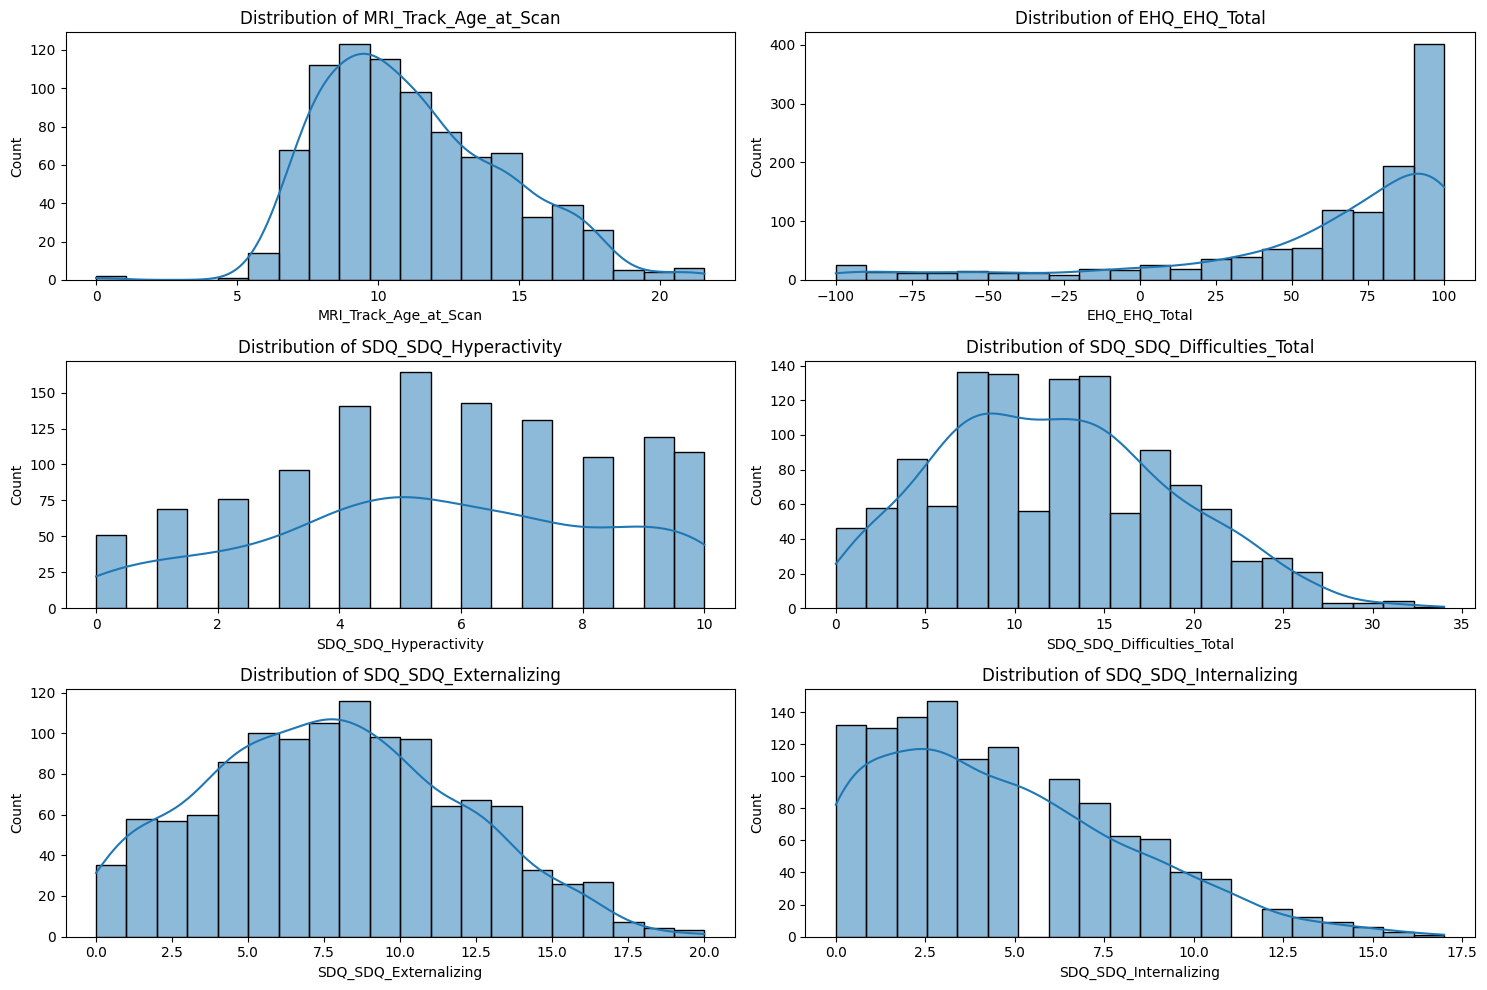

Quantitative feature statistics:
        MRI_Track_Age_at_Scan  EHQ_EHQ_Total  SDQ_SDQ_Hyperactivity  \
count             853.000000    1200.000000            1204.000000   
mean               11.245678      59.514750               5.539037   
std                 3.234372      49.744631               2.807063   
min                 0.000000    -100.000000               0.000000   
25%                 8.803901      46.670000               4.000000   
50%                10.739219      77.800000               6.000000   
75%                13.460871      94.470000               8.000000   
max                21.564453     100.000000              10.000000   

       SDQ_SDQ_Difficulties_Total  SDQ_SDQ_Externalizing  \
count                 1204.000000            1204.000000   
mean                    12.213455               7.613787   
std                      6.517330               4.130399   
min                      0.000000               0.000000   
25%                      7.000000  

In [23]:
quant_cols = [
    'MRI_Track_Age_at_Scan', 'EHQ_EHQ_Total', 'SDQ_SDQ_Hyperactivity',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(quant_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


print("Quantitative feature statistics:\n", df[quant_cols].describe())

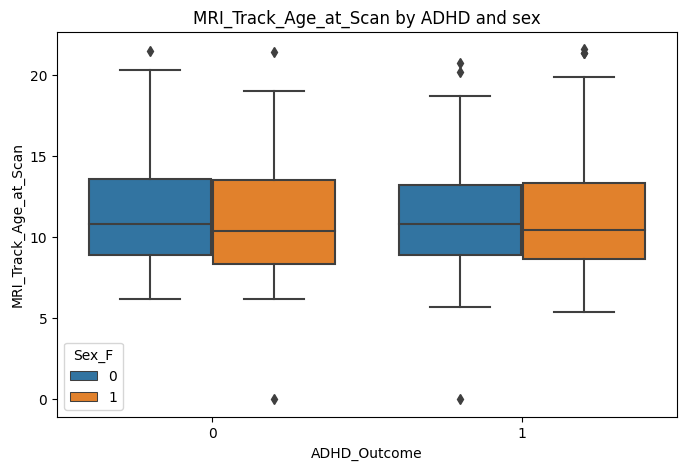

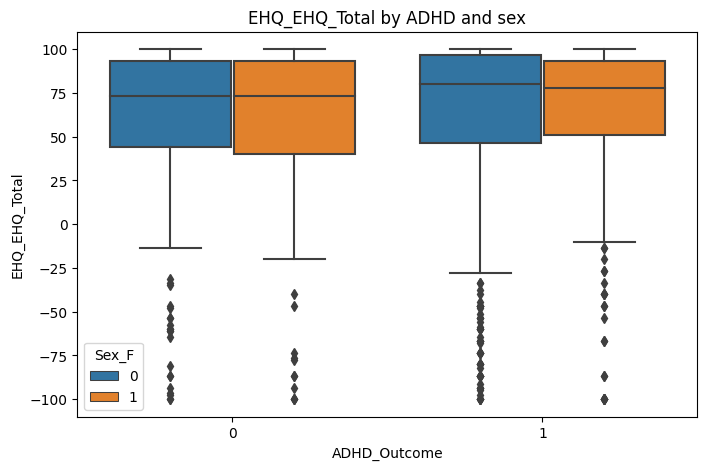

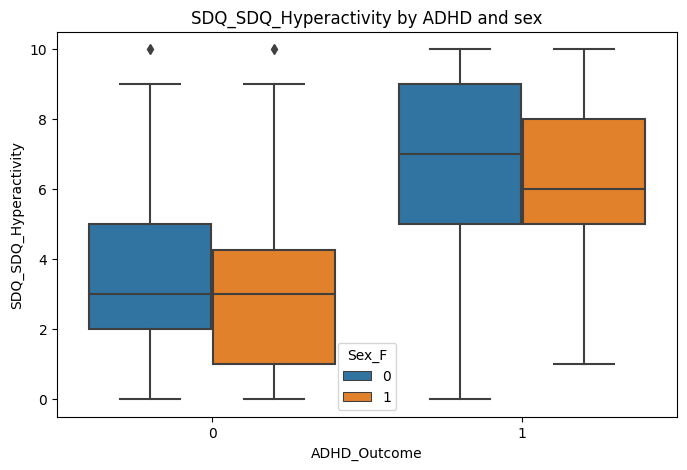

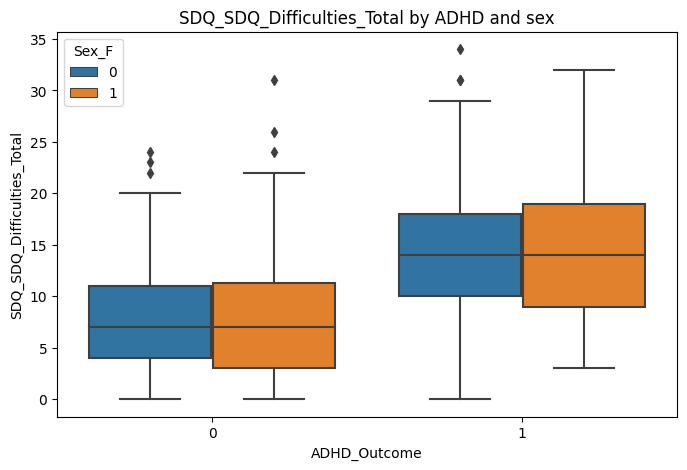

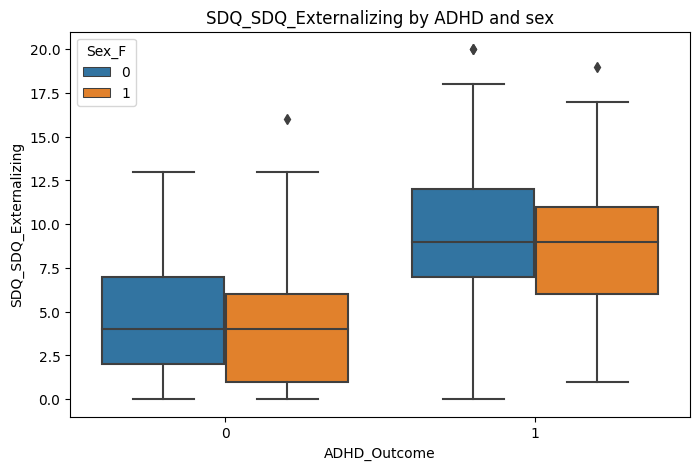

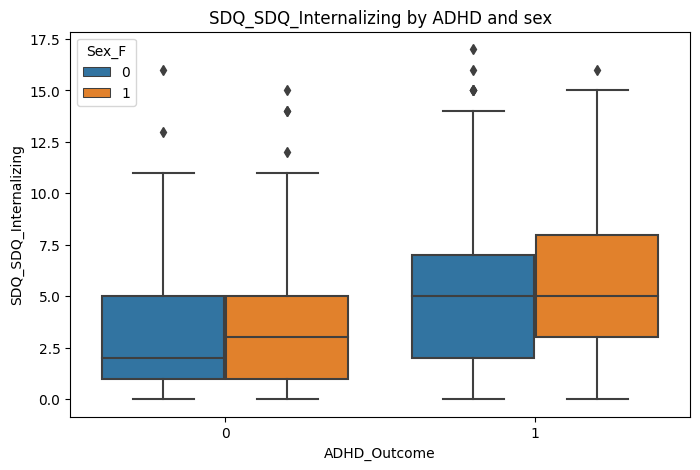

In [24]:
for col in quant_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='ADHD_Outcome', y=col, hue='Sex_F', data=df)
    plt.title(f"{col} by ADHD and sex")
    plt.show()

interval columns not set, guessing: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 'ADHD_Outcome', 'Sex_F']


/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable participant_id is large: 1213. Are you sure this is not an interval variable? Analysis for pairs of variables including participant_id can be slow.
  warnings.warn(
/tmp/ipykernel_35/1136202252.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


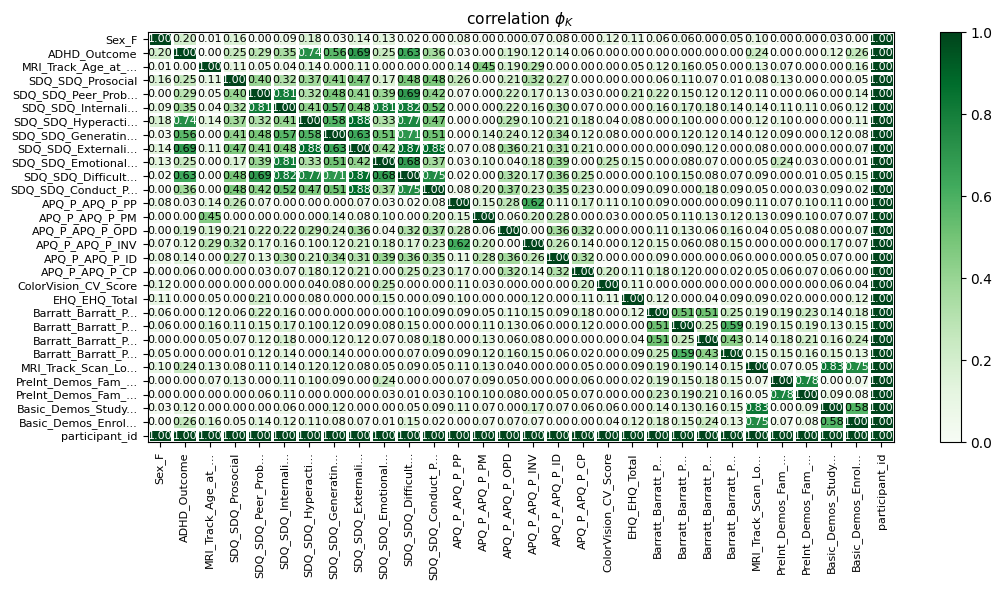

In [25]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = df.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

## 🧠 DATA PREPROCESS AND Model Training

In [46]:
def load_fmri_and_targets(fmri_path, target_path):
    fmri_df = pd.read_csv(fmri_path)
    target_df = pd.read_excel(target_path)
    df_merged = pd.merge(fmri_df, target_df, on="participant_id")
    return df_merged


def preprocess_fmri_data_and_balance(df_merged, n_components=200):
    # 1. Split into features and labels
    X_fmri = df_merged.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
    y_fmri = df_merged[["Sex_F", "ADHD_Outcome"]]

    # 2. Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fmri)

    # 3. First SMOTE: balance by ADHD outcome
    smote = SMOTE(random_state=42)
    X_res_adhd, y_res_adhd = smote.fit_resample(X_scaled, y_fmri["ADHD_Outcome"])

    # 4. Restore sex labels for the expanded ADHD samples
    sex_labels = np.tile(
        y_fmri["Sex_F"],
        int(np.ceil(len(X_res_adhd) / len(y_fmri)))
    )[:len(X_res_adhd)]

    # 5. Second SMOTE: balance by sex
    X_res_final, y_res_sex = smote.fit_resample(X_res_adhd, sex_labels)

    # 6. Construct final target DataFrame
    y_adhd_final = np.tile(
        y_res_adhd,
        int(np.ceil(len(y_res_sex) / len(y_res_adhd)))
    )[:len(y_res_sex)]
    y_final = pd.DataFrame({
        "Sex_F": y_res_sex,
        "ADHD_Outcome": y_adhd_final
    })

    # 7. Apply PCA after SMOTE
    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(X_res_final)

    return X_reduced, y_final


def train_xgboost_multioutput(X, y, use_scale_weight=True):
    from xgboost import XGBClassifier
    from sklearn.multioutput import MultiOutputClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix

    # 0) Drop rows where any target is NaN
    mask = y.notnull().all(axis=1)
    
    # Clean y
    y_clean = y.loc[mask].reset_index(drop=True)
    
    # Clean X: if it's a DataFrame, use .loc; else assume numpy array
    if hasattr(X, "loc"):
        X_clean = X.loc[mask].reset_index(drop=True)
    else:
        X_clean = X[mask]

    # 1) Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
    )

    # 2) Compute class weight for the sex classifier
    if use_scale_weight:
        n0 = (y_train["Sex_F"] == 0).sum()
        n1 = (y_train["Sex_F"] == 1).sum()
        scale_pos_weight = n0 / n1
    else:
        scale_pos_weight = 1

    # 3) Define separate XGBoost classifiers
    sex_clf = XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        scale_pos_weight=scale_pos_weight, random_state=42
    )
    adhd_clf = XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
    )

    # 4) Wrap into MultiOutputClassifier
    model = MultiOutputClassifier(estimator=sex_clf)
    model.estimators_ = [sex_clf, adhd_clf]
    model.fit(X_train, y_train)

    # 5) Predict and evaluate
    y_pred = model.predict(X_test)
    print("=== SEX PREDICTION ===")
    print(classification_report(y_test["Sex_F"], y_pred[:, 0]))
    print(confusion_matrix(y_test["Sex_F"], y_pred[:, 0]))
    print("\n=== ADHD PREDICTION ===")
    print(classification_report(y_test["ADHD_Outcome"], y_pred[:, 1]))
    print(confusion_matrix(y_test["ADHD_Outcome"], y_pred[:, 1]))

    return model



from sklearn.impute import SimpleImputer

def prepare_tabular_data(cat_path, num_path, target_path):
    # 1) Load tables
    cat_df   = pd.read_excel(cat_path)
    num_df   = pd.read_excel(num_path)
    sol_df   = pd.read_excel(target_path)

    # 2) Merge on participant_id
    df = cat_df.merge(num_df, on="participant_id") \
               .merge(sol_df, on="participant_id")

    # 3) Basic fill for key columns
    df['PreInt_Demos_Fam_Child_Ethnicity'] = (
        df['PreInt_Demos_Fam_Child_Ethnicity'].fillna('Missing')
    )
    df['MRI_Track_Age_at_Scan'] = (
        df.groupby('Basic_Demos_Study_Site')['MRI_Track_Age_at_Scan']
          .transform(lambda x: x.fillna(x.median()))
    )
    df = df[(df['MRI_Track_Age_at_Scan'] >= 5) & (df['MRI_Track_Age_at_Scan'] <= 20)]

    # 4) One-hot encode categorical features
    df = pd.get_dummies(
        df,
        columns=[
            'Basic_Demos_Study_Site',
            'PreInt_Demos_Fam_Child_Ethnicity',
            'PreInt_Demos_Fam_Child_Race',
            'MRI_Track_Scan_Location'
        ],
        prefix=['site','ethnicity','race','location']
    )

    # 5) Categorize EHQ and encode
    df['EHQ_Category'] = pd.cut(
        df['EHQ_EHQ_Total'],
        bins=[-float('inf'), -50, 0, 50, float('inf')],
        labels=['Left','Mild Left','Mild Right','Right']
    )
    df = pd.get_dummies(df, columns=['EHQ_Category'], prefix='ehq')

    # 6) Handle parental education properly (no chained assignment)
    df = df.assign(
        Barratt_P1_Edu = lambda d: d['Barratt_Barratt_P1_Edu'].replace(0, np.nan),
        Barratt_P2_Edu = lambda d: d['Barratt_Barratt_P2_Edu'].replace(0, np.nan),
    )
    mode1 = df['Barratt_P1_Edu'].mode()[0]
    mode2 = df['Barratt_P2_Edu'].mode()[0]
    df = df.assign(
        Barratt_P1_Edu = df['Barratt_P1_Edu'].fillna(mode1),
        Barratt_P2_Edu = df['Barratt_P2_Edu'].fillna(mode2),
    )

    # 7) Map education to numeric codes
    edu_map = {3.0:0,6.0:1,9.0:2,12.0:3,15.0:4,18.0:5,21.0:6}
    df['Barratt_P1_Edu'] = df['Barratt_P1_Edu'].map(edu_map)
    df['Barratt_P2_Edu'] = df['Barratt_P2_Edu'].map(edu_map)

    # 8) One-hot occupations
    df = pd.get_dummies(
        df,
        columns=['Barratt_Barratt_P1_Occ','Barratt_Barratt_P2_Occ'],
        prefix=['P1_Occ','P2_Occ']
    )

    # 9) Ensure booleans → ints
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    # 10) Scale quantitative features
    quant_cols = [
        'EHQ_EHQ_Total','ColorVision_CV_Score',
        'APQ_P_APQ_P_CP','APQ_P_APQ_P_ID','APQ_P_APQ_P_INV',
        'APQ_P_APQ_P_OPD','APQ_P_APQ_P_PM','APQ_P_APQ_P_PP',
        'SDQ_SDQ_Conduct_Problems','SDQ_SDQ_Difficulties_Total',
        'SDQ_SDQ_Emotional_Problems','SDQ_SDQ_Externalizing',
        'SDQ_SDQ_Generating_Impact','SDQ_SDQ_Hyperactivity',
        'SDQ_SDQ_Internalizing','SDQ_SDQ_Peer_Problems',
        'SDQ_SDQ_Prosocial','MRI_Track_Age_at_Scan'
    ]
    scaler = StandardScaler()
    df[quant_cols] = scaler.fit_transform(df[quant_cols])

    # 11) Separate X/y
    X = df.drop(columns=["participant_id","Sex_F","ADHD_Outcome"])
    y = df[["Sex_F","ADHD_Outcome"]]
    return X, y


def balance_tabular_data(X, y):
    # 0) Copy
    Xc = X.copy()

    # 1) Impute any remaining NaNs in numeric columns
    num_cols = Xc.select_dtypes(include=[np.number]).columns
    imp = SimpleImputer(strategy="median")
    Xc[num_cols] = imp.fit_transform(Xc[num_cols])

    # 2) Convert any bools to int
    bool_cols = Xc.select_dtypes(include='bool').columns
    Xc[bool_cols] = Xc[bool_cols].astype(int)

    # 3) Two-stage SMOTE
    smote = SMOTE(random_state=42)

    # Stage 1: balance ADHD outcome
    Xc["Sex_F"] = y["Sex_F"]
    X_adhd, y_adhd = smote.fit_resample(Xc,      y["ADHD_Outcome"])
    sex_lbl = X_adhd["Sex_F"].reset_index(drop=True)
    X_adhd = X_adhd.drop(columns="Sex_F").reset_index(drop=True)

    # Stage 2: balance sex
    X_bal, y_sex = smote.fit_resample(X_adhd, sex_lbl)

    # 4) Build final y
    y_adhd_rep = pd.Series(y_adhd).reset_index(drop=True)
    y_final = pd.DataFrame({
        "Sex_F":        y_sex,
        "ADHD_Outcome": y_adhd_rep
    })

    return X_bal, y_final





In [44]:
X_tabular, y_tabular = prepare_tabular_data(cat_path, num_path, target_path)
X_tabular_bal, y_tabular_bal = balance_tabular_data(X_tabular, y_tabular)

model_tabular = train_xgboost_multioutput(X_tabular_bal, y_tabular_bal, use_scale_weight=True)

=== SEX PREDICTION ===
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       229
           1       0.52      0.46      0.49       101

    accuracy                           0.71       330
   macro avg       0.65      0.64      0.64       330
weighted avg       0.70      0.71      0.70       330

[[187  42]
 [ 55  46]]

=== ADHD PREDICTION ===
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86       165
         1.0       0.83      0.92      0.87       165

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.87      0.87      0.87       330

[[134  31]
 [ 13 152]]


In [47]:
# === FMRI DATA ===
print("\n=== PREPARE FMRI DATA ===")
df_fmri = load_fmri_and_targets(fmri_path, target_path)
X_fmri_bal, y_fmri_bal = preprocess_fmri_data_and_balance(df_fmri, n_components=200)

print("\n=== TRAIN MODEL===")
model_fmri = train_xgboost_multioutput(X_fmri_bal, y_fmri_bal, use_scale_weight=False)


=== PREPARE FMRI DATA ===


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


=== TRAIN MODEL===
=== SEX PREDICTION ===
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       220
           1       0.71      0.75      0.73       221

    accuracy                           0.72       441
   macro avg       0.72      0.72      0.72       441
weighted avg       0.72      0.72      0.72       441

[[153  67]
 [ 56 165]]

=== ADHD PREDICTION ===
              precision    recall  f1-score   support

           0       0.73      0.56      0.64       200
           1       0.70      0.83      0.76       241

    accuracy                           0.71       441
   macro avg       0.71      0.70      0.70       441
weighted avg       0.71      0.71      0.70       441

[[113  87]
 [ 42 199]]


In [48]:
# 1. Extract feature names and importances from the trained models
feature_names   = X_tabular_bal.columns
sex_importances = model_tabular.estimators_[0].feature_importances_
adhd_importances = model_tabular.estimators_[1].feature_importances_

# 2. Create a DataFrame of importances
df_imp = pd.DataFrame({
    'feature':        feature_names,
    'importance_sex':  sex_importances,
    'importance_adhd': adhd_importances
})

# 3. Compute average importance and select top 10
df_imp['importance_avg'] = df_imp[['importance_sex', 'importance_adhd']].mean(axis=1)
top10 = df_imp.sort_values('importance_avg', ascending=False).head(10).reset_index(drop=True)

# 4. Style and display the table
top10.style \
     .background_gradient(subset=['importance_avg'], cmap='Blues') \
     .bar(subset=['importance_sex','importance_adhd'], color=['lightcoral','lightseagreen']) \
     .set_caption("Top 10 Features by Average Importance")

,feature,importance_sex,importance_adhd,importance_avg
0,SDQ_SDQ_Hyperactivity,0.017157,0.120471,0.068814
1,P1_Occ_45.0,0.017866,0.037763,0.027814
2,location_1.0,0.010870,0.031863,0.021366
3,ehq_Right,0.019653,0.022504,0.021078
4,ethnicity_0.0,0.011968,0.029821,0.020895
5,P1_Occ_25.0,0.027565,0.013989,0.020777
6,P1_Occ_5.0,0.015899,0.025411,0.020655
7,Basic_Demos_Enroll_Year,0.014128,0.026051,0.020089
8,SDQ_SDQ_Externalizing,0.013990,0.025840,0.019915
9,location_2.0,0.017813,0.021633,0.019723


## 📈 Model Evaluation

In [49]:
def prepare_fmri_test_data(fmri_path):
    fmri_df = pd.read_csv(fmri_path)
    participant_ids = fmri_df["participant_id"]
    X = fmri_df.drop(columns=["participant_id"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=200, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, participant_ids


X_test_fmri, test_ids_fmri = prepare_fmri_test_data("/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

preds_fmri = model_fmri.predict(X_test_fmri)
preds_fmri_df = pd.DataFrame(preds_fmri, columns=["Sex_F_pred_fmri", "ADHD_pred_fmri"])
print(preds_fmri_df.head())


   Sex_F_pred_fmri  ADHD_pred_fmri
0                0               1
1                0               0
2                0               1
3                0               1
4                0               1


In [50]:
test_cat_path = "/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_num_path = "/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"

def prepare_tabular_test_data(cat_path, num_path):
    cat_df = pd.read_excel(cat_path)
    num_df = pd.read_excel(num_path)
    df = cat_df.merge(num_df, on="participant_id")
    df['PreInt_Demos_Fam_Child_Ethnicity'] = df['PreInt_Demos_Fam_Child_Ethnicity'].fillna('Missing')
    df['MRI_Track_Age_at_Scan'] = df['MRI_Track_Age_at_Scan'].fillna(
        df.groupby('Basic_Demos_Study_Site')['MRI_Track_Age_at_Scan'].transform('median')
    )

    df = pd.get_dummies(df, columns=[
        'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity',
        'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location'
    ], prefix=['site', 'ethnicity', 'race', 'location'])
    df['EHQ_Category'] = pd.cut(df['EHQ_EHQ_Total'],
                                bins=[-float('inf'), -50, 0, 50, float('inf')],
                                labels=['Left', 'Mild Left', 'Mild Right', 'Right'])
    df = pd.get_dummies(df, columns=['EHQ_Category'], prefix='ehq')
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].replace(0, np.nan)
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].replace(0, np.nan)
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].fillna(df['Barratt_Barratt_P1_Edu'].mode()[0])
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].fillna(df['Barratt_Barratt_P2_Edu'].mode()[0])
    edu_map = {3.0: 0, 6.0: 1, 9.0: 2, 12.0: 3, 15.0: 4, 18.0: 5, 21.0: 6}
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].map(edu_map)
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].map(edu_map)
    df = pd.get_dummies(df, columns=['Barratt_Barratt_P1_Occ','Barratt_Barratt_P2_Occ'],
                        prefix=['P1_Occ', 'P2_Occ'])
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)
    quant = ['EHQ_EHQ_Total', 'ColorVision_CV_Score',
             'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
             'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
             'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
             'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
             'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
             'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems',
             'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df[quant] = scaler.fit_transform(df[quant])

    participant_ids = df["participant_id"]
    X_test = df.drop(columns=["participant_id"])
    return X_test, participant_ids

X_test_tab, test_ids_tab = prepare_tabular_test_data(test_cat_path, test_num_path)

X_test_tab_aligned = X_test_tab.reindex(columns=X_tabular_bal.columns, fill_value=0)

preds_tabular = model_tabular.predict(X_test_tab_aligned)
preds_tabular_df = pd.DataFrame(preds_tabular, columns=["Sex_F_pred_tab", "ADHD_pred_tab"])
print(preds_tabular_df.head())


   Sex_F_pred_tab  ADHD_pred_tab
0               0              1
1               1              0
2               1              0
3               1              1
4               0              1


In [51]:
# 2. Probability predictions
probs_fmri    = model_fmri.predict_proba(X_test_fmri)      # adjust here if needed
probs_tabular = model_tabular.predict_proba(X_test_tab_aligned)

# 3. Ensemble example (70% tabular for ADHD, 70% fMRI for Sex)
adhd_proba_tab  = probs_tabular[1][:, 1]  # ADHD probability
adhd_proba_fmri = probs_fmri[1][:, 1]

sex_proba_tab   = probs_tabular[0][:, 1]  # Sex probability
sex_proba_fmri  = probs_fmri[0][:, 1]

final_adhd = (0.7 * adhd_proba_tab  + 0.3 * adhd_proba_fmri) >= 0.2
final_sex  = (0.3 * sex_proba_tab   + 0.7 * sex_proba_fmri)  >= 0.2


## 📨 Submission Preparation
Final predictions and submission formatting.

In [52]:
submission = pd.DataFrame({"participant_id": test_ids_fmri})
submission["ADHD_final"] = final_adhd.astype(int)
submission["Sex_final"] = final_sex.astype(int)
submission.to_csv("/content/final_submission_proba3.csv", index=False)